In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

%matplotlib inline
import matplotlib.pyplot as plt

# Read in Raw Data

In [3]:
TRAIN_DATA_PATH = '../data/commute-times-train.csv'
TEST_DATA_PATH = '../data/commute-times-test.csv'

In [49]:
train_data_raw = pd.read_csv(TRAIN_DATA_PATH, 
                             parse_dates=['time_of_day_ts'])
test_data_raw = pd.read_csv(TEST_DATA_PATH,
                            parse_dates=['time_of_day_ts'])

In [50]:
train_data_raw['dataset'] = 'TRAIN'
test_data_raw['dataset'] = 'TEST'

raw_data = pd.concat([train_data_raw, test_data_raw])

In [51]:
raw_data.head()

,Unnamed: 0,source_latitude,source_longitude,destination_latitude,destination_longitude,time_of_day_ts,commute_type,commute_time,dataset
0,0,-0.182809,0.361579,0.485623,0.300347,2018-08-13 16:56:00,BUS,25.156297,TRAIN
1,1,0.160297,0.064330,0.702545,-0.116307,2018-08-13 18:19:00,CAR,12.937429,TRAIN
2,2,0.762229,0.486693,0.197252,0.790051,2018-08-13 17:36:00,BIKE,29.013729,TRAIN
3,3,0.187947,0.508487,-0.372924,-0.914006,2018-08-13 07:41:00,CAR,18.215423,TRAIN
4,4,-0.431013,-0.600620,0.729273,0.215633,2018-08-13 15:56:00,TRAIN,11.196802,TRAIN


# Raw Data (One Variable) Visualizations

## Source and Destination of Commute

Text(0.5,1,'Destination Of Commute Lat, Long')

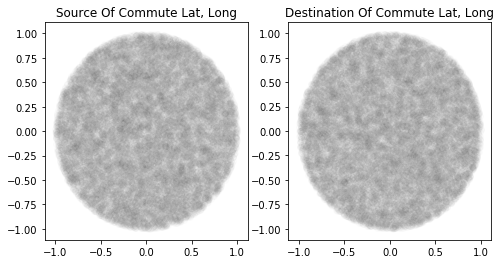

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].scatter(train_data_raw['source_latitude'],
               train_data_raw['source_longitude'],
               color="grey", alpha=0.02)
axs[0].set_title("Source Of Commute Lat, Long")
axs[1].scatter(train_data_raw['destination_latitude'],
               train_data_raw['destination_longitude'],
               color="grey", alpha=0.02)
axs[1].set_title("Destination Of Commute Lat, Long")

## Count of Commute Types

Text(0,0.5,'Volume of Commutes')

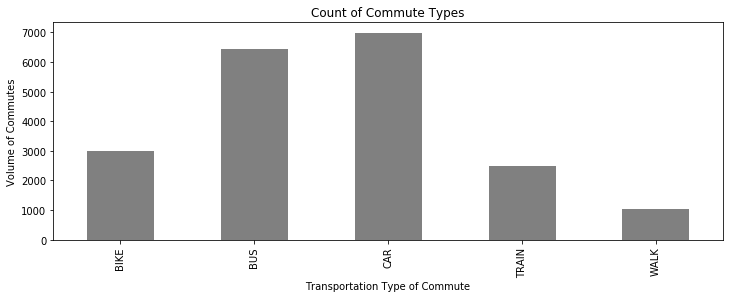

In [63]:
fig, ax = plt.subplots(figsize=(12, 4))
train_data_raw.groupby('commute_type').size().plot(
    ax=ax, kind='bar', color="grey")
ax.set_title("Count of Commute Types")
ax.set_xlabel("Transportation Type of Commute")
ax.set_ylabel("Volume of Commutes")

## Distribution of Commute Time

Text(0,0.5,'Volume of Commutes')

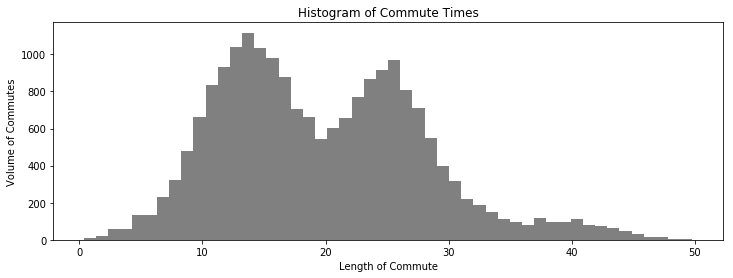

In [62]:
fig, ax = plt.subplots(figsize=(12, 4))
train_data_raw['commute_time'].plot(
    ax=ax, kind='hist', bins=50, color="grey")
ax.set_title("Histogram of Commute Times")
ax.set_xlabel("Length of Commute")
ax.set_ylabel("Volume of Commutes")

**Discussion.**

Discuss multi-modal nature.  What could be causing that?  **A:** We may have different subpopulations in the data with different commute time behaviour, transportation type is a possibility.

## Distribution of Time of Day

We'd like to draw a histogram of time of day, but this is not easy to do on the raw timestamp data.  To make our lives easy, we'll convert this into a decimal between zero and twenty-four.

In [57]:
def timestamp_to_decimal(ts):
    """Convert a timestamp datum into a decimal between zero and twenty-four.
    
    Parameters
    ----------
    ts: pd.Series of datetime.
    """
    return ts.dt.hour + (1/60)*ts.dt.minute

train_data_raw['time_of_day'] = timestamp_to_decimal(
    train_data_raw['time_of_day_ts'])
test_data_raw['time_of_day'] = timestamp_to_decimal(
    test_data_raw['time_of_day_ts'])

Notice how we have to apply the **same transformation** to our training and testing data.  I'll show you a trick soon that will save us some trouble.

Text(0,0.5,'Volume of Commutes')

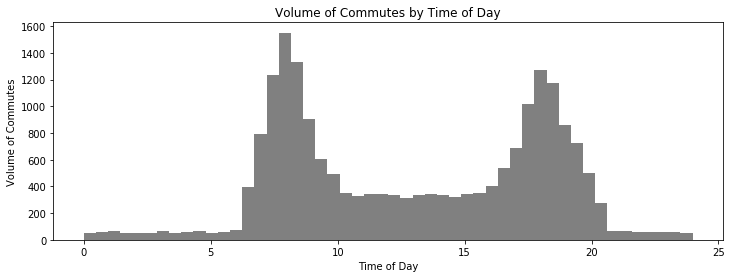

In [61]:
fig, ax = plt.subplots(figsize=(12, 4))
train_data_raw['time_of_day'].plot(
    ax=ax, kind='hist', bins=50, color='grey')
ax.set_title("Volume of Commutes by Time of Day")
ax.set_xlabel("Time of Day")
ax.set_ylabel("Volume of Commutes")

**Discussion**

We would expect high volume times to have longer commutes.  Plotting the commute time by the time of day may give some insight into the situation.

## Distance of Commute

The distance of the commute is not explicitly included in the dataset!  Instead, we have the coordinates of the source and destination of the commute.  This should allow us to calculate the distance of the commute, but we have a couple of options:

  - The **Euclidean Distance** is the straight line distance between the source and the target.  It is calucated from the usual formula inspired by the Pythagorean Theorem.

In [115]:
def euclidean_distance(source_x, source_y, target_x, target_y):
    return np.sqrt((source_x - target_x)**2 + (source_y - target_y)**2)

train_data_raw['euclidean_distance'] = euclidean_distance(
    train_data_raw['source_latitude'], train_data_raw['source_longitude'],
    train_data_raw['destination_latitude'], train_data_raw['destination_longitude'])
test_data_raw['euclidean_distance'] = euclidean_distance(
    test_data_raw['source_latitude'], test_data_raw['source_longitude'],
    test_data_raw['destination_latitude'], test_data_raw['destination_longitude'])

Text(0,0.5,'Volume of Commutes')

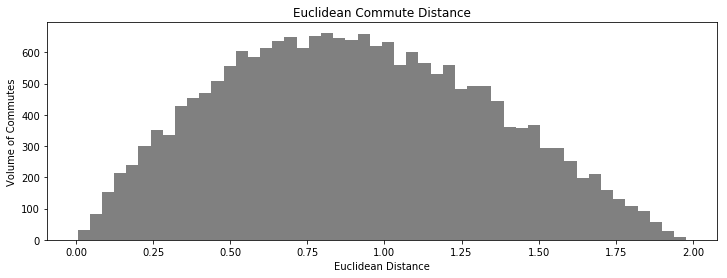

In [117]:
fig, ax = plt.subplots(figsize=(12, 4))
train_data_raw['euclidean_distance'].plot(
    ax=ax, kind='hist', bins=50, color='grey')
ax.set_title("Euclidean Commute Distance")
ax.set_xlabel("Euclidean Distance")
ax.set_ylabel("Volume of Commutes")

  - The **Taxicab Distance** is the total distance a car would travel between the source and destination coordinates *if it only traveled parallel to the x and y axies*.

In [118]:
def taxicab_distance(source_x, source_y, target_x, target_y):
    return np.abs(source_x - target_x) + np.abs(source_y - target_y)

train_data_raw['taxicab_distance'] = taxicab_distance(
    train_data_raw['source_latitude'], train_data_raw['source_longitude'],
    train_data_raw['destination_latitude'], train_data_raw['destination_longitude'])
test_data_raw['taxicab_distance'] = taxicab_distance(
    test_data_raw['source_latitude'], test_data_raw['source_longitude'],
    test_data_raw['destination_latitude'], test_data_raw['destination_longitude'])

Text(0,0.5,'Volume of Commutes')

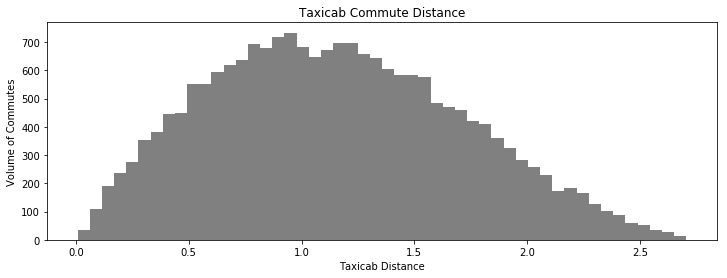

In [119]:
fig, ax = plt.subplots(figsize=(12, 4))
train_data_raw['taxicab_distance'].plot(
    ax=ax, kind='hist', bins=50, color='grey')
ax.set_title("Taxicab Commute Distance")
ax.set_xlabel("Taxicab Distance")
ax.set_ylabel("Volume of Commutes")

**Discussion**

Which distance measure do you think more likely to be related to the commute time?  Why?

# Relationship Visualizations

## The Effect Of Commute Type on Commute Time

Let's try to look into the relationship between the commute type and commute time.  We have hypothesized that the commute type may have something to do with the multi-modal behaviour of commute time.

A powerful technique in this area is the principle of **small multiples**, draw many small seperate plots in a way that the readers eye can easily compare them.

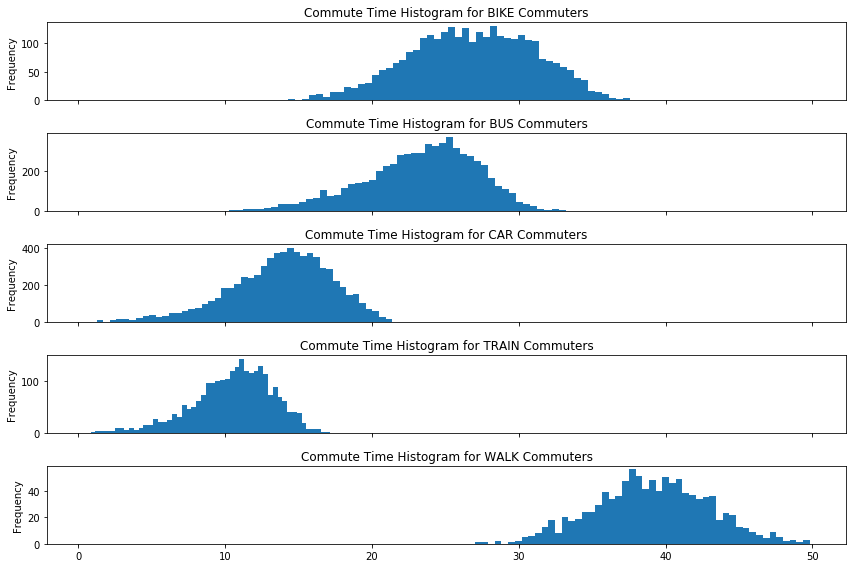

In [136]:
# Get a list of all the unique commute types.
commute_types = np.unique(train_data_raw['commute_type'])

# We want one axis (i.e. on plotting area) for each commute type.
# Note the sharey argument, this forces all out plots to have the 
# same x-axis range.
fig, axs = plt.subplots(len(commute_types), 1, figsize=(12, 8), sharex=True)

# Subset the data by each commute type, then plot a histogram of commute
# times for each seperate commute type individually.
for commute_type, ax in zip(commute_types, axs):
    commute_type_mask = train_data_raw['commute_type'] == commute_type
    train_for_commute_type = train_data_raw[commute_type_mask]
    train_for_commute_type['commute_time'].plot(ax=ax, kind="hist", bins=50)
    ax.set_title(f"Commute Time Histogram for {commute_type} Commuters")

fig.tight_layout()

It looks like the commute time definately has an effect.

The results here are intuitive:  train commutes are speedy, while walking or biking to work takes longer.

Here's an alternative visualization of this effect (though making this one is a bit more involved).

In [108]:
def convert_to_numeric(catagorical):
    classes = catagorical.unique()
    classes_mapping = {cls: i for i, cls in enumerate(classes)}
    classes_inv_mapping = {i: cls for i, cls in enumerate(classes)}
    classes_numeric = catagorical.apply(lambda cls: classes_mapping[cls])
    return classes_numeric, classes_inv_mapping

def catagorical_plot(ax, catagorical, y, jitter_width=0.1):
    numeric, classes_mapping = convert_to_numeric(catagorical)
    # This is called adding "jitter" to a scatterplot.
    noise = np.random.normal(0.0, jitter_width, size=len(catagorical))
    ax.scatter(numeric + noise, y, color="grey", alpha=0.1)
    
    box_data = list(y.groupby(numeric))
    ax.boxplot([data for _, data in box_data], positions=range(len(box_data)))
    ax.set_xticks(list(classes_mapping))
    ax.set_xticklabels([classes_mapping[name] for name, _ in box_data])

Text(0.5,1,'Effect of Commute Type on Commute Time')

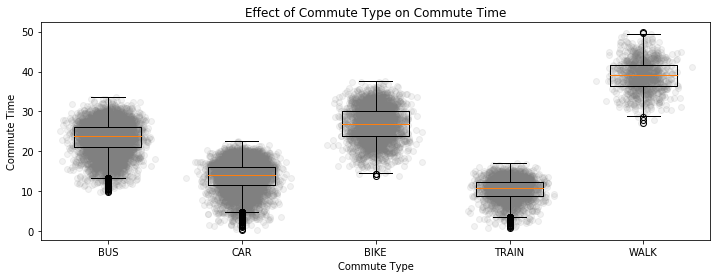

In [109]:
fig, ax = plt.subplots(figsize=(12, 4))

catagorical_plot(ax, train_data_raw['commute_type'], train_data_raw['commute_time'])
ax.set_xlabel("Commute Type")
ax.set_ylabel("Commute Time")
ax.set_title("Effect of Commute Type on Commute Time")

This tells the same story in a different way.  Here we see each individual commute time as a point, so all the data is represented exactly.  Each cloud of points are the commute times for each individual type of commute.

The left-right scatter within each type of commute is not meaningful, it just serves to spread the points out so our eye can get an idea of what is going on.  If we take away the scatter, it looks really bad:

Text(0.5,1,'Effect of Commute Type on Commute Time')

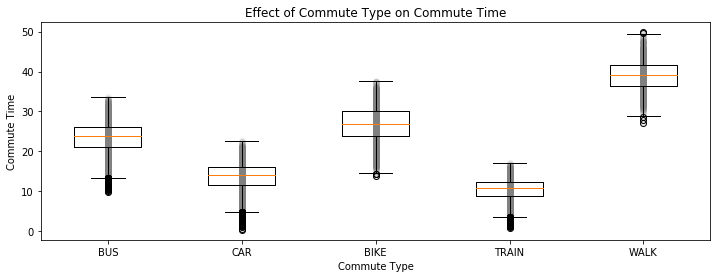

In [110]:
fig, ax = plt.subplots(figsize=(12, 4))

catagorical_plot(ax, 
                 train_data_raw['commute_type'], 
                 train_data_raw['commute_time'],
                 jitter_width=0.0)
ax.set_xlabel("Commute Type")
ax.set_ylabel("Commute Time")
ax.set_title("Effect of Commute Type on Commute Time")

Not as good!

**Discussion**

Do you expect commute type to be predictive of commute time?

## The Effect of Commute Distance on Commute Time

A scatter plot of commute time by commute distance can be illuminating.

Text(0.5,1,'Commute Time by Euclidean Commute Distance')

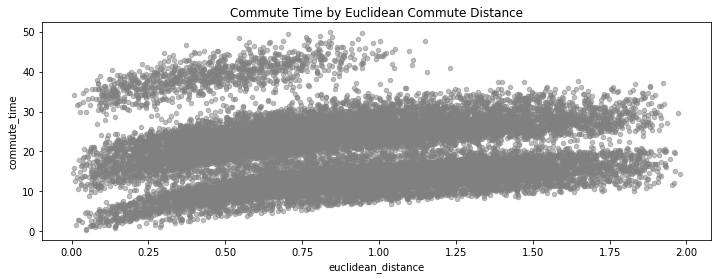

In [125]:
fig, ax = plt.subplots(figsize=(12, 4))

train_data_raw.plot(ax=ax, kind='scatter', x='euclidean_distance', y='commute_time',
                    color='gray', alpha=0.5)
ax.set_title("Commute Time by Euclidean Commute Distance")

Text(0.5,1,'Commute Time by Taxicab Commute Distance')

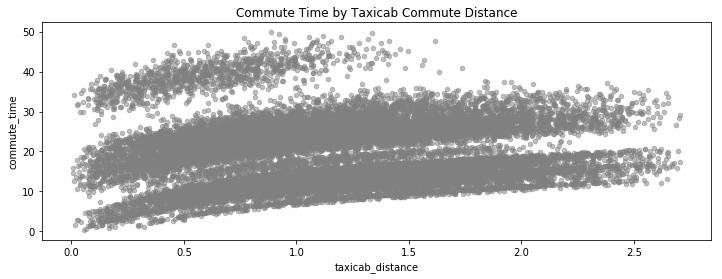

In [127]:
fig, ax = plt.subplots(figsize=(12, 4))

train_data_raw.plot(ax=ax, kind='scatter', x='taxicab_distance', y='commute_time',
                    color='gray', alpha=0.5)
ax.set_title("Commute Time by Taxicab Commute Distance")

There is clearly a realationship between commute distance and commute time!  Though it is subtle:

  - There is *definately* some overall relationship between the distance of the commute and the time of the commute.  Commutes covering a larger distance tend to take longer, which makes intuitive sense.
  - There is some interesting *banding* in these plots.  The relationships seem to fall into different catagories.
  - The structure of the Taxicab distance plot is more defined than the structure of the Euclidean distance plot.  This maybe leads us to suspect that the taxicab distance is closer to capturing some essential truth of the situation.

Let's look into the banding.  We suspect that each defined band is some subpopulation of our commuters.  We have a clear canidate for what this could be, out commute type variable.

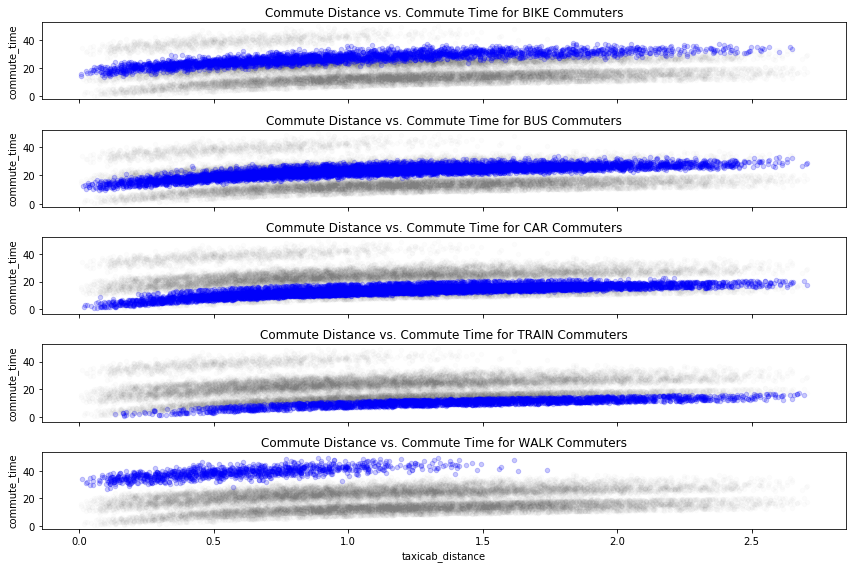

In [142]:
# This code is based on the example from eariler which creates histograms of 
# commute time for each individual commute type.
commute_types = np.unique(train_data_raw['commute_type'])

fig, axs = plt.subplots(len(commute_types), 1, figsize=(12, 8), sharex=True)

for commute_type, ax in zip(commute_types, axs):
    commute_type_mask = train_data_raw['commute_type'] == commute_type
    train_for_commute_type = train_data_raw[commute_type_mask]
    train_data_raw.plot(
        ax=ax, kind="scatter", 
        x='taxicab_distance', y='commute_time',
        color='gray', alpha=0.02)
    train_for_commute_type.plot(
        ax=ax, kind="scatter", 
        x='taxicab_distance', y='commute_time',
        color='blue', alpha=0.2)
    ax.set_title(f"Commute Distance vs. Commute Time for {commute_type} Commuters")

fig.tight_layout()

We see clearly that the banding structure in the scatterplot is caused by the different types of commute.

## The Effect of Time of Day on Commute Time

Finally, let's look into the relationship between the commute time and the time of day.

Text(0.5,1,'Commute Time by Euclidean Commute Distance')

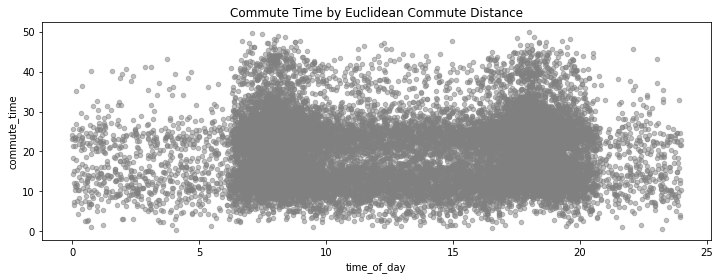

In [137]:
fig, ax = plt.subplots(figsize=(12, 4))

train_data_raw.plot(ax=ax, kind='scatter', x='time_of_day', y='commute_time',
                    color='gray', alpha=0.5)
ax.set_title("Commute Time by Time of Day")

We again see some banding structure, so lets break it out by commute type to get a clearer picture of what's going on.

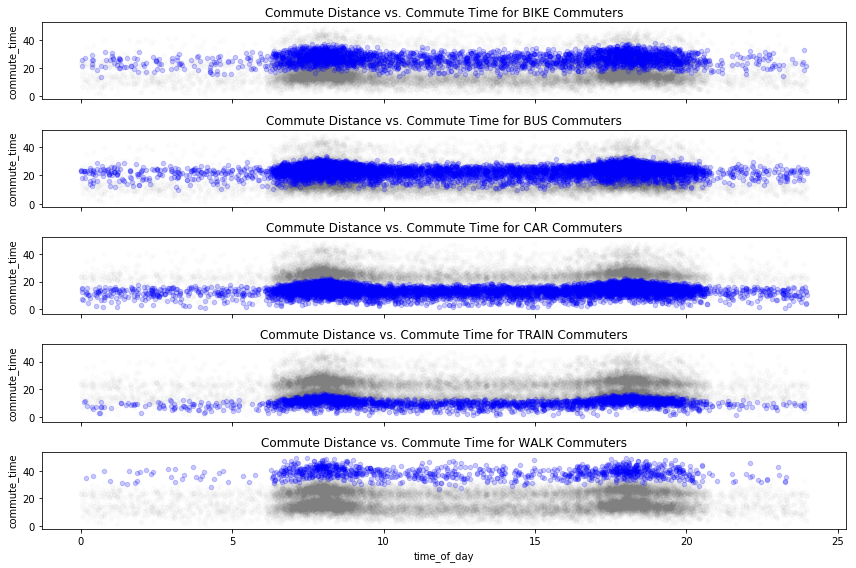

In [141]:
commute_types = np.unique(train_data_raw['commute_type'])

fig, axs = plt.subplots(len(commute_types), 1, figsize=(12, 8), sharex=True)

for commute_type, ax in zip(commute_types, axs):
    commute_type_mask = train_data_raw['commute_type'] == commute_type
    train_for_commute_type = train_data_raw[commute_type_mask]
    train_data_raw.plot(
        ax=ax, kind="scatter", 
        x='time_of_day', y='commute_time',
        color='gray', alpha=0.02)
    train_for_commute_type.plot(
        ax=ax, kind="scatter", 
        x='time_of_day', y='commute_time',
        color='blue', alpha=0.2)
    ax.set_title(f"Commute Distance vs. Commute Time for {commute_type} Commuters")

fig.tight_layout()

Similar to before, the bands are caused by the different commute types.

The relationship between time of day and commute time is subtle.  It's definately not in increasing style of relationship (nor could it be...).  Instead, it looks like commute times are largely driven by the distance, but they tend to be longer during high traffic times of day.

# Feature Creation

## Commute Type Indicators

## Time of Day Indicators